# Nearest Neighbor Embeddings Classification with Qdrant

FiftyOne provides [powerful workflows](https://voxel51.com/docs/fiftyone/user_guide/brain.html) centered around embeddings, including pre-annotation, finding annotation mistakes, finding hard samples, and visual similarity searches. However, performing nearest neighbor searches on large datasets requires the right infrastructure.

Vector search engines have been developed for the purpose of efficiently storing, searching, and managing embedding vectors. [Qdrant](https://qdrant.tech/) is a vector database designed to perform an approximate nearest neighbor search (ANN) on dense neural embeddings, which is a key part of any production-ready system that is expected to scale to large amounts of data. And best of all, it's open-source!

In this tutorial, we'll load the MNIST dataset into FiftyOne and then use Qdrant to perform ANN-based classification, where the data points will be classified by selecting the most common ground truth label among the **K** nearest points from our training dataset. In other words, for each test example, we'll select the K nearest neighbors in embedding space and assign the best label by voting. We'll then evaluate the results of this classification strategy using FiftyOne.

**So, what's the takeaway?**

FiftyOne and Qdrant can be used together to easily perform an approximate nearest neighbors search on the embeddings of your datasets and kickstart pre-annotation workflows.

## Setup

If you haven’t already, install FiftyOne:


In [ ]:
!pip install fiftyone

We'll also need the Qdrant Python client:

In [ ]:
!pip install qdrant_client

In this example, we will also be making use of torchvision models from the [FiftyOne Model Zoo](https://voxel51.com/docs/fiftyone/user_guide/model_zoo/index.html#).

In [ ]:
!pip install torchvision

### Qdrant installation
If you want to start using the semantic search with Qdrant, you need to run an instance of it, as this tool works in a client-server manner. The easiest way to do this is to use an official Docker image and start Qdrant with just a single command:



In [ ]:
!docker run -p "6333:6333" -p "6334:6334" -d qdrant / qdrant

After running the command we’ll have the Qdrant server running, with HTTP API exposed at port 6333 and gRPC interface at 6334.

## Loading the dataset

There are several steps we need to take to get things running smoothly. First of all, we need to load the MNIST dataset and extract the train examples from it, as we're going to use them in our search operations. To make everything even faster, we're not going to use all the examples, but just 2500 samples. We can use the [FiftyOne Dataset Zoo](https://voxel51.com/docs/fiftyone/user_guide/dataset_zoo/index.html) to load the subset of MNIST we want in just one line of code.

In [1]:
import fiftyone as fo
import fiftyone.zoo as foz

In [3]:
# Load the data
dataset = foz.load_zoo_dataset("mnist", max_samples=2500)
train_view = dataset.match_tags(tags=["train"])

Split 'train' already downloaded
Split 'test' already downloaded
Loading 'mnist' split 'train'
 100% |███████████████| 2500/2500 [4.1s elapsed, 0s remaining, 685.3 samples/s]      
Loading 'mnist' split 'test'
 100% |███████████████| 2500/2500 [4.0s elapsed, 0s remaining, 644.8 samples/s]      
Dataset 'mnist-2500' created


Let's start by taking a look at the dataset in the [FiftyOne App](https://voxel51.com/docs/fiftyone/user_guide/app.html).


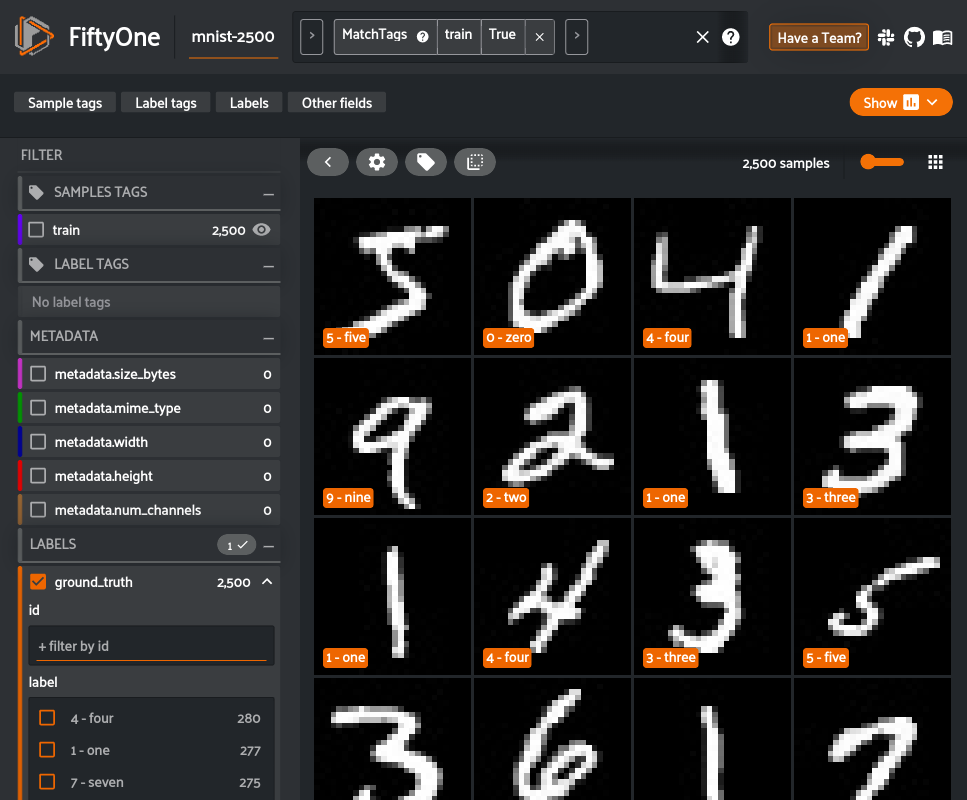

In [34]:
session = fo.launch_app(train_view)

In [35]:
session.freeze()  # screenshot the App

## Generating embeddings

The next step is to generate embeddings on the samples in the dataset. This can always be done outside of FiftyOne, with your own custom models. However, FiftyOne also provides various different models in the [FiftyOne Model Zoo](https://voxel51.com/docs/fiftyone/user_guide/model_zoo/index.html) that can be used right out of the box to generate embeddings.

In this example, we use [MobileNetv2](https://voxel51.com/docs/fiftyone/user_guide/model_zoo/models.html#mobilenet-v2-imagenet-torch) trained on ImageNet to compute an embedding for each image.

In [4]:
# Compute embeddings
model = foz.load_zoo_model("mobilenet-v2-imagenet-torch")

train_embeddings = train_view.compute_embeddings(model)

 100% |███████████████| 2500/2500 [3.7m elapsed, 0s remaining, 7.7 samples/s]       


## Loading embeddings into Qdrant

Qdrant allows storing not only vectors but also some corresponding attributes - each data point has a related vector and optionally a JSON payload attached to it. We want to use this to pass in the ground truth label to make sure we can make our prediction later on.

In [5]:
ground_truth_labels, train_sample_ids = train_view.values(["ground_truth.label", "id"])
train_payload = [
    {"ground_truth": gt, "sample_id": sid} for gt, sid in zip(ground_truth_labels, train_sample_ids)
]

Having the embedding created, we can simply start communicating with the Qdrant server. An instance of `QdrantClient` is then helpful, as it encloses all the required methods. Let's connect and create a collection of points, simply called `"mnist"`. The vector size is dependent on the model output, so if we want to experiment with a different model another day, then we will just need to import a different one, but the rest will be kept the same. Eventually, after making sure the collection exists, we can send all the vectors along with their payloads containing their true labels.

In [14]:
import qdrant_client as qc
from qdrant_client.http.models import Distance, VectorParams


# Load the train embeddings into Qdrant
def create_and_upload_collection(embeddings, payload, collection_name="mnist"):
    client = qc.QdrantClient(host="localhost")
    client.recreate_collection(
        collection_name=collection_name,
        vectors_config=VectorParams(size=embeddings.shape[1],
                                    distance=Distance.COSINE),
    )
    client.upload_collection(
        collection_name=collection_name,
        vectors=embeddings,
        payload=payload,
    )
    return client

In [7]:
client = create_and_upload_collection(train_embeddings, train_payload)

{
  "vector_size": 1280,
  "distance": "Cosine",
  "shard_number": null,
  "on_disk_payload": null,
  "hnsw_config": null,
  "wal_config": null,
  "optimizers_config": null
}


40it [00:34,  1.16it/s]


## Nearest neighbor classification

Now to perform inference on the dataset. We can create the embeddings for our test dataset, but just ignore the ground truth and try to find it out using ANN, then compare if both match. Let's take one step at a time and start with creating the embeddings.

In [9]:
# Assign the labels to test embeddings by selecting the most common label
# among the neighbours of each sample
test_view = dataset.match_tags(tags=["test"])
test_embeddings = test_view.compute_embeddings(model)

 100% |███████████████| 2500/2500 [3.9m elapsed, 0s remaining, 12.1 samples/s]      


Time for some magic. Let's simply iterate through the test dataset's samples and their corresponding embeddings, and use the search operation to find the 15 closest embeddings from the training set. We'll also need to select the payloads, as they contain the ground truth labels which are required to find the most common label in the neighborhood of a particular point. Python's `Counter` class will be helpful to avoid any boilerplate code. The most common label will be stored as an `"ann_prediction"` on each test sample in FiftyOne.

The function below takes an embedding vector as input, uses the Qdrant search capability to find the nearest neighbors to the test embedding, generated a class prediction, and returns a FiftyOne [Classification](https://voxel51.com/docs/fiftyone/user_guide/using_datasets.html#classification) object that we can store in our [FiftyOne dataset](https://voxel51.com/docs/fiftyone/user_guide/using_datasets.html).

In [13]:
import collections


def generate_fiftyone_classification(embedding, collection_name="mnist"):
    search_results = client.search(
        collection_name=collection_name,
        query_vector=embedding,
        with_payload=True,
        top=15,
    )
    # Count the occurrences of each class and select the most common label
    # with the confidence estimated as the number of occurrences of the most
    # common label divided by a total number of results.
    counter = collections.Counter(
        [point.payload["ground_truth"] for point in search_results]
    )
    predicted_class, occurences_num = counter.most_common(1)[0]
    confidence = occurences_num / sum(counter.values())
    prediction = fo.Classification(
        label=predicted_class, confidence=confidence
    )
    return prediction

In [10]:
from tqdm import tqdm

predictions = []

# Call Qdrant to find the closest data points
for embedding in tqdm(test_embeddings):
    prediction = generate_fiftyone_classification(embedding)
    predictions.append(prediction)

test_view.set_values("ann_prediction", predictions)

100%|██████████| 2500/2500 [01:42<00:00, 24.40it/s]


By the way, we estimated the confidence by calculating the fraction of samples belonging to the most common label. That gives us an intuition of how sure we were while predicting the label for each case and can be used in FiftyOne to easily spot confusing examples.

## Evaluation in FiftyOne

It's high time for some results! Let's start by visualizing how this classifier has performed. We can easily launch the [FiftyOne App](https://voxel51.com/docs/fiftyone/user_guide/app.html) to view the ground truth, predictions, and images themselves.


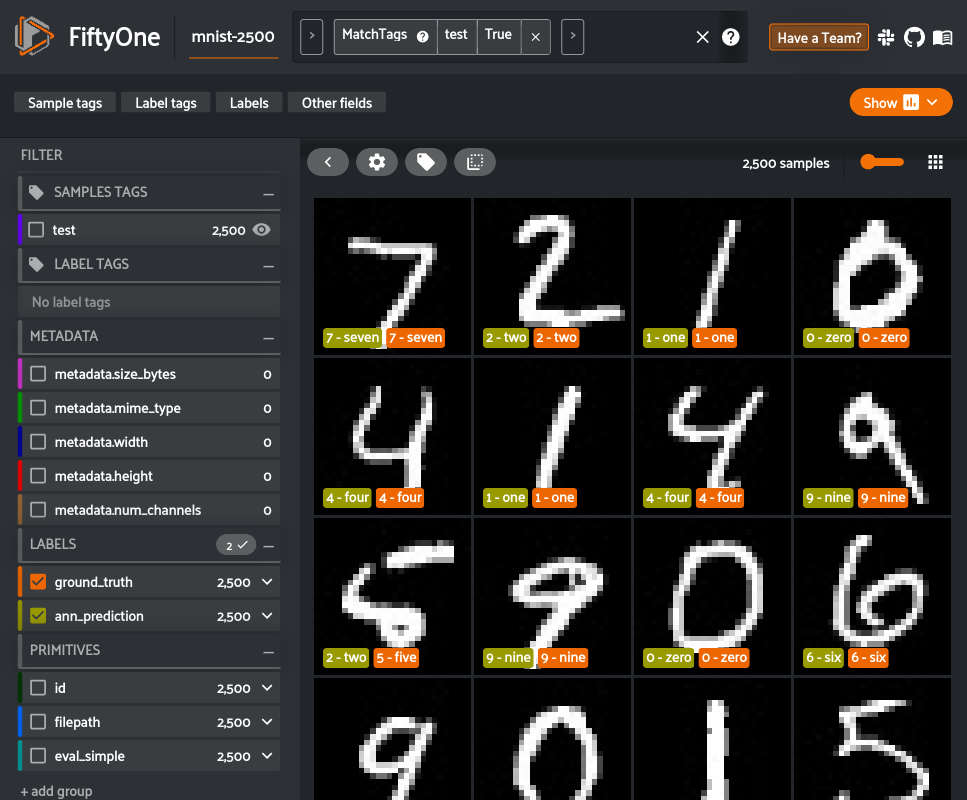

In [6]:
session = fo.launch_app(test_view)

In [7]:
session.freeze()  # screenshot the App

FiftyOne provides a variety of built-in [methods for evaluating your model](https://voxel51.com/docs/fiftyone/user_guide/evaluation.html) predictions, including regressions, classifications, detections, polygons, instance and semantic segmentations, on both image and video datasets. In two lines of code, we can compute and print an evaluation report of our classifier.

In [11]:
# Evaluate the ANN predictions, with respect to the values in ground_truth
results = test_view.evaluate_classifications(
    "ann_prediction", gt_field="ground_truth", eval_key="eval_simple"
)

# Display the classification metrics
results.print_report()

              precision    recall  f1-score   support

    0 - zero       0.87      0.98      0.92       219
     1 - one       0.94      0.98      0.96       287
     2 - two       0.87      0.72      0.79       276
   3 - three       0.81      0.87      0.84       254
    4 - four       0.84      0.92      0.88       275
    5 - five       0.76      0.77      0.77       221
     6 - six       0.94      0.91      0.93       225
   7 - seven       0.83      0.81      0.82       257
   8 - eight       0.95      0.91      0.93       242
    9 - nine       0.94      0.87      0.90       244

    accuracy                           0.87      2500
   macro avg       0.88      0.87      0.87      2500
weighted avg       0.88      0.87      0.87      2500



After performing the evaluation in FiftyOne, we can use the `results` object to generate an [interactive confusion matrix](https://voxel51.com/docs/fiftyone/user_guide/plots.html#confusion-matrices) allowing us to click on cells and automatically update the App to show the corresponding samples.

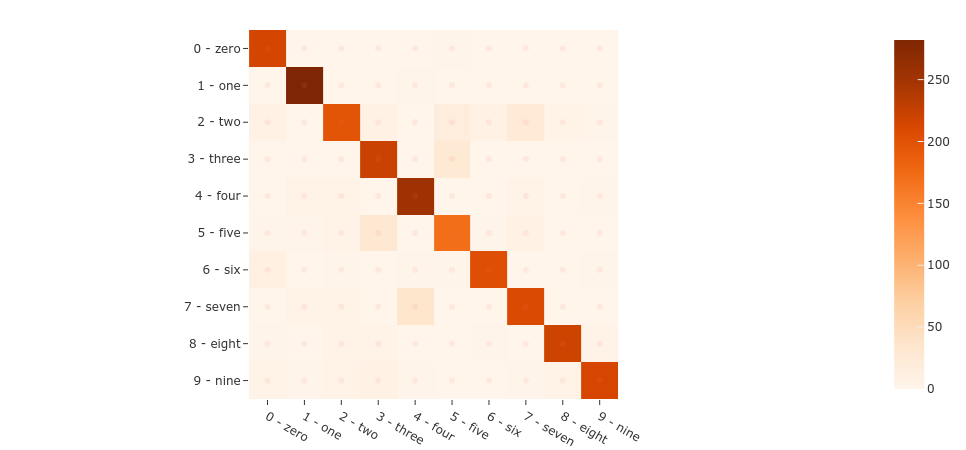

In [37]:
plot = results.plot_confusion_matrix()
plot.show()

In [ ]:
session.plots.attach(plot)

Let's dig in a bit further. We can use the [sophisticated query language](https://voxel51.com/docs/fiftyone/user_guide/using_views.html#filtering) of FiftyOne to easily find all predictions that did not match the ground truth, yet were predicted with high confidence. These will generally be the most confusing samples for the dataset and the ones from which we can gather the most insight.

In [3]:
from fiftyone import ViewField as F

# Display results in the FiftyOne App, but include only the wrong predictions that were
# predicted with high confidence
false_view = (
    test_view
    .match(F("eval_simple") == False)
    .filter_labels("ann_prediction", F("confidence") > 0.7)
)


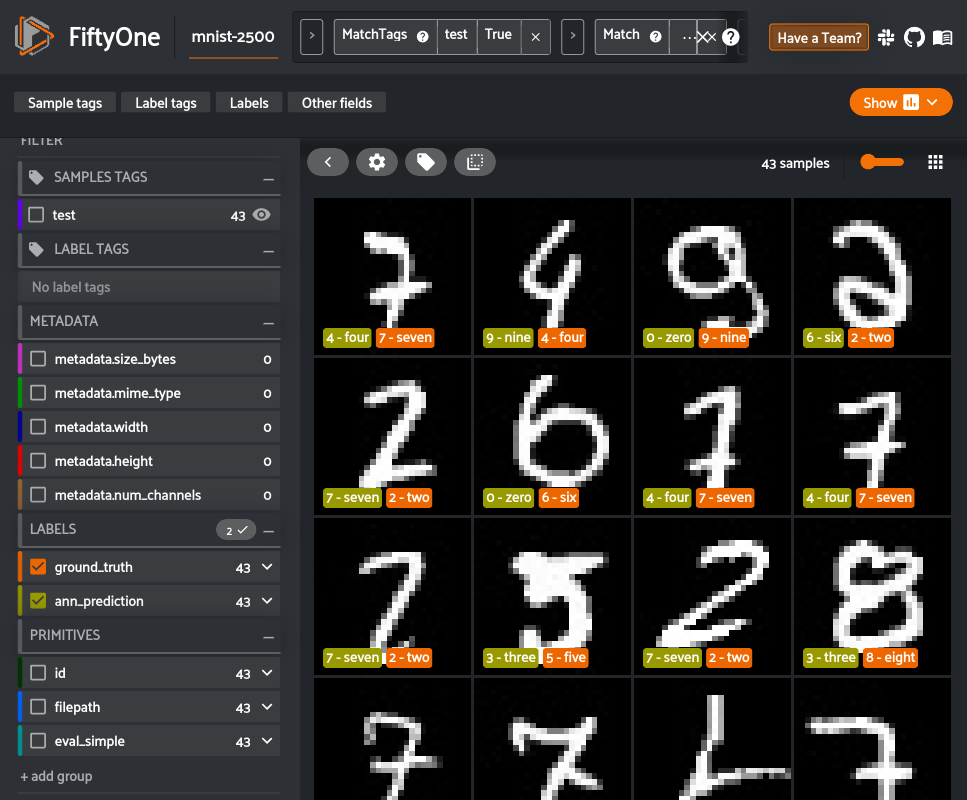

In [4]:
session = fo.launch_app(false_view)

In [5]:
session.freeze()  # screenshot the App

These are the most confusing samples for the model and, as you can see, they are fairly irregular compared to other images in the dataset. A next step we could take to improve the performance of the model could be to use FiftyOne to curate additional samples similar to these. From there, those samples can then be annotated through the integrations between FiftyOne and tools like [CVAT](https://voxel51.com/docs/fiftyone/integrations/cvat.html) and [Labelbox](https://voxel51.com/docs/fiftyone/integrations/labelbox.html). Additionally, we could use some more vectors for training or just perform a fine-tuning of the model with similarity learning, for example using the triplet loss. But right now this example of using FiftyOne and Qdrant for vector similarity classification is working pretty well already.

And that's it! As simple as that, we created an ANN classification model using FiftyOne with Qdrant as an embeddings backend, so finding the similarity between vectors can stop being a bottleneck as it would in the case of a traditional k-NN.

## BDD100k example

Let's take everything we learned in the previous example and apply it to a more realisitc use-case. In this section, we take a look at how to use nearest neighbor embedding classification for pre-annotation of the BDD100k road-scene dataset to apply a scene-level label determining the time of day.

This dataset is also available in the FiftyOne Dataset Zoo. If you want to follow along youself, you will need to register at https://bdd-data.berkeley.edu in order to get links to download the data. See the [zoo docs](https://voxel51.com/docs/fiftyone/user_guide/dataset_zoo/datasets.html?highlight=bdd100k#dataset-zoo-bdd100k) for details on loading the dataset.

We’ll be working with a 1,000 image subset of the validation split:

In [8]:
import fiftyone as fo
import fiftyone.zoo as foz

# The path to the source files that you manually downloaded
source_dir = "/path/to/dir-with-bdd100k-files"

dataset = foz.load_zoo_dataset(
    "bdd100k",
    split="validation",
    source_dir=source_dir,
    max_samples=1000,
)

Split 'validation' already prepared
Loading 'bdd100k' split 'validation'
 100% |███████████████| 1000/1000 [21.4s elapsed, 0s remaining, 48.2 samples/s]      
Dataset 'bdd100k-validation-1000' created


Let's split this dataset so that 30% of the samples are missing the `timeofday` classification. We will then compute this classification using nearest neighbors.

In [9]:
import fiftyone.utils.random as four

four.random_split(dataset, {"train": 0.7, "test": 0.3})

train_view = dataset.match_tags("train")
test_view = dataset.match_tags("test")

# Remove labels from test view for this example
test_view.set_field("timeofday", None).save()

Note: This is a larger model than the one used in the previous example. It is recommended this is run on a machine with GPU support or in a Colab notebook.

In [10]:
# Load a resnet from the model zoo
model = foz.load_zoo_model("resnet50-imagenet-torch")

# Verify that the model exposes embeddings
print(model.has_embeddings)
# True

# Compute embeddings for each image
train_embeddings = train_view.compute_embeddings(model)

True
 100% |█████████████████| 700/700 [24.8m elapsed, 0s remaining, 0.5 samples/s]    


In [21]:
train_embeddings.shape

(700, 2048)

From here we can use the functions defined above to load the embeddings into Qdrant and then generate classifications for the dataset. Specifically, we are looking to generate pre-annotations of the `timeofday` label.

In [11]:
ground_truth_labels, train_sample_ids = train_view.values(["timeofday.label", "id"])
train_payload = [
    {"ground_truth": gt, "sample_id": sid} for gt, sid in zip(ground_truth_labels, train_sample_ids)
]

In [15]:
client = create_and_upload_collection(train_embeddings, train_payload, collection_name="bdd")

{
  "vector_size": 2048,
  "distance": "Cosine",
  "shard_number": null,
  "on_disk_payload": null,
  "hnsw_config": null,
  "wal_config": null,
  "optimizers_config": null
}


11it [00:05,  1.89it/s]


In [16]:
test_embeddings = test_view.compute_embeddings(model)

 100% |█████████████████| 300/300 [10.2m elapsed, 0s remaining, 0.5 samples/s]    


In [23]:
from tqdm import tqdm

predictions = []
# Call Qdrant to find the closest data points
for embedding in tqdm(test_embeddings):
    prediction = generate_fiftyone_classification(embedding, collection_name="bdd")
    predictions.append(prediction)

test_view.set_values("timeofday", predictions)

100%|██████████| 300/300 [00:09<00:00, 30.38it/s]


Now we can pull up the FiftyOne App to inspect the `timeofday` labels on the test set to inspect how the classifier performed.


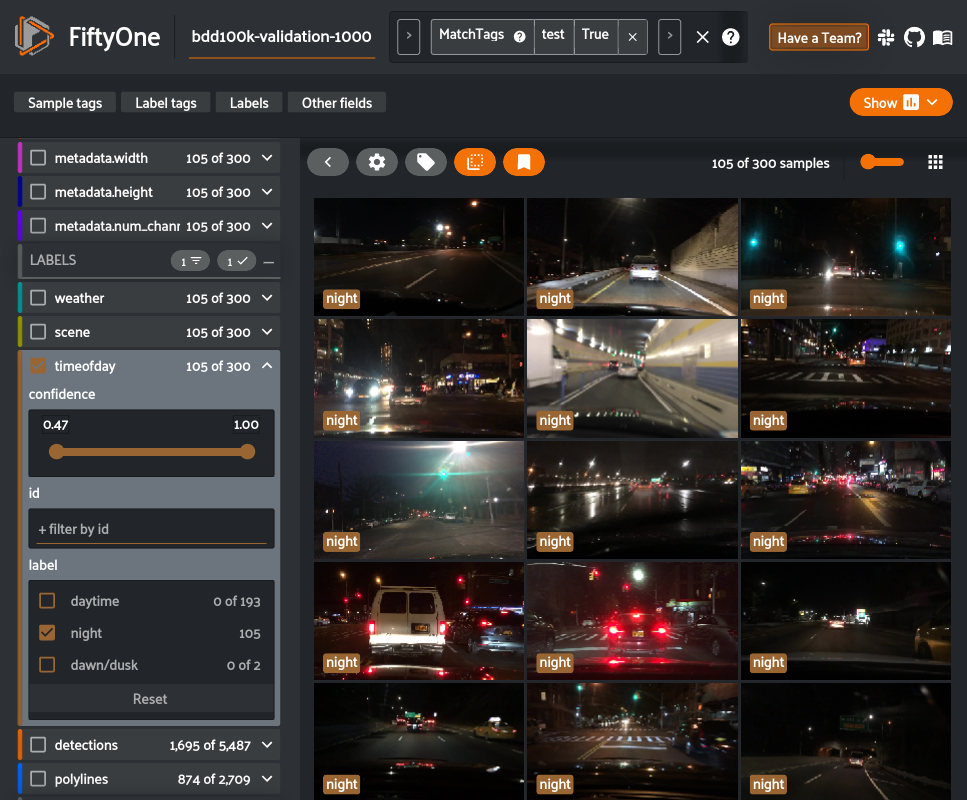

In [24]:
# Inspect how the annotations look
session = fo.launch_app(test_view)


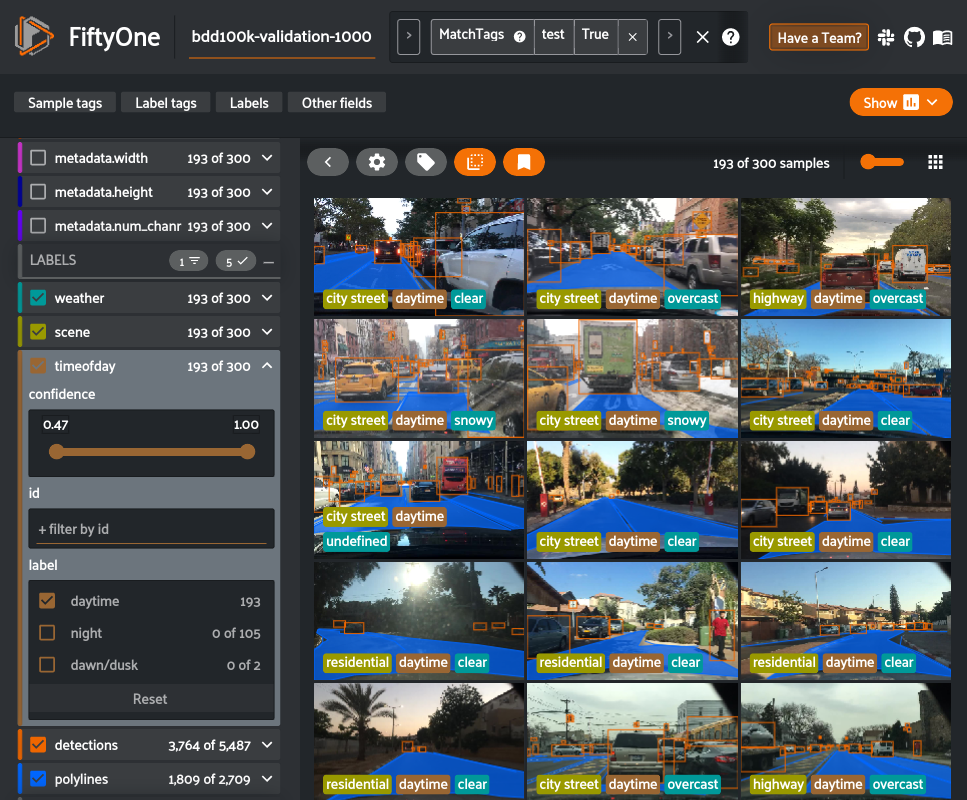

In [26]:
session.show()

In [27]:
session.freeze()  # screenshot the App

From here, there are multiple ways forward to further refine the preannotations. Two of these paths are:

* Bringing in a QA team to use the [FiftyOne App to tag mistakes](https://voxel51.com/docs/fiftyone/user_guide/app.html#tags-and-tagging)
* Using the [mistakenness feature](https://voxel51.com/docs/fiftyone/user_guide/brain.html#sample-hardness) of the FiftyOne Brain to automatically detect potential annotation mistakes

Either way, these preannotations can then easily be passed to the annotation tools that FiftyOne integrates with like [CVAT](https://voxel51.com/docs/fiftyone/integrations/cvat.html), [Labelbox](https://voxel51.com/docs/fiftyone/integrations/labelbox.html), etc. for further refinement.

## Summary

FiftyOne and Qdrant can be used together to efficiently perform a nearest neighbor search on embeddings and act on the results on your image and video datasets. The beauty of this process lies in its flexibility and repeatability. You can easily load additional ground truth labels for new fields into both FiftyOne and Qdrant and repeat this pre-annotation process using the existing embeddings. This can quickly cut down on annotation costs and result in higher-quality datasets, faster.